# Copula Pair's Trading Basic Strategy

This notebook demonstrates the usage of the `copula_strategy_basic` module.
The framework is originally proposed in 
- Liew, Rong Qi, and Yuan Wu. "Pairs trading: A copula approach."
- Stander, Yolanda, Daniël Marais, and Ilse Botha. "Trading strategies with copulas."

## A Bare Minimum Intro to Copula

### What Merit Does It Have
Consider having a pair of cointegrated stocks. 
By analyzing their time series, one can calculate their standardized price gap as part of a distance approach, or project their long-run mean as in a cointegrated system as part of a cointegration approach. 
However, none of the two methods are built with the assumptions on distributions from the stocks' time series, which may lead to unused information.
Further, just using a single parameter (i.e., Euclidean distance) to quantify two coupled time series might have fundamentally simplified the problem too much.
The copula model naturally incorporates their marginal distributions, together with other interesting properties from each copula inherited from their own structures, e.g., tail dependency for capturing rare and/or extreme moments like large, cointegrated swings in the market.

Briefly speaking, a copula is a tool to capture details of how two random variables are “correlated”.
By having a more detailed modeling framework, we expect the pairs trading strategy followed to be more realistic and robust, and possibly to bring more trading opportunities.

### Definitions for Bivariate Copula
(**Definition using Sklar's Theorem**) For two random variables $S_1$, $S_2 \in [-\infty, \infty]$.
$S_1$ and $S_2$ have their own fixed, continuous CDFs $F_1, F_2$.
Consider their (cumulative) joint distribution $H(s_1, s_2) := P(S_1 \le s_1, S_2 \le s_2)$.
Now take the uniformly distributed quantile random variable $U_1(S_1)$, $U_2(S_2)$, for every pair
$(u_1, u_2)$ drawn from the pair's quantile we define the **bivariate copula**
$C: [0, 1] \times [0, 1] \rightarrow [0, 1]$ as:

$$
    \begin{align}
    C(u_1, u_2) &= P(U_1 \le u_1, U_2 \le u_2) \\
    &= P(S_1 \le F_1^{-1}(u_1), S_2 \le F_2^{-1}(u_2)) \\
    &= H(F_1^{-1}(u_1), F_2^{-1}(u_2))
    \end{align}
$$
where $F_1^{-1}$ and $F_2^{-1}$ are quasi-inverse of the marginal CDFs $F_1$ and $F_2$.
The definition, although mathematically more fundamental, is not used as much in trading.
Instead, cumulative conditional probabilities and copula density are used more often, which we will define as below:

### Conditional Probabilities
$$
    \begin{align}
    P(U_1\le u_1 | U_2 = u_2) &:= \frac{\partial C(u_1, u_2)}{\partial u_2}, \\
    P(U_2\le u_2 | U_1 = u_1) &:= \frac{\partial C(u_1, u_2)}{\partial u_1}.
    \end{align}
$$
### Copula Density

$$
    c(u_1 , u_2) := \frac{\partial^2 C(u_1, u_2)}{\partial u_1 \partial u_2},
$$
which by definition is the probability density.

For interested readers, Nelsen's book [An Introduction to Copulas](https://www.springer.com/gp/book/9780387286594) and note [Properties and applications of copulas: A brief survey](http://w4.stern.nyu.edu/ioms/docs/sg/seminars/nelsen.pdf) presents more rigorously and thoroughly on the subject.

## Basic Strategy (Conditional Probabilities Threshold)

### Logic
This was originally proposed in [Liew et al., 2013] and [Stander et al., 2013].
We start with a pair of stocks of interest $S_1$ and $S_2$, which can be selected by various methods.
For example, using the Engle-Granger test for cointegration.
By consensus, we define the spread as $S_1$ in relation to $S_2$.
e.g. Short the spread means buying $S_1$ and/or selling $S_2$.

Use **cumulative log return** data of the stocks during the training/formation period, we proceed with a **pseudo-MLE** fit to establish a copula that reflects the relation of the two stocks during the training/formation period.

**Note**: <br>
the type of processed data fed in need to be **approximately stationary**.
i.e., $\mathbb{E}[X(t_1)] \approx \mathbb{E}[X(t_2)]$ for time series $X$, for all $t_1, t_2$ in
the scope of interest.
For example, if we model each stock's price to have a log-Normal distribution, then the price itself cannot be stationary after some time.
Using cumulative log return has the same issue if the time span is sufficiently long.
One can consider just using the daily return or its logarithm instead, given that the stock's price has a log-Normal distribution. i.e., $\frac{X(t+1)}{X(t)}$ or $\ln \left( \frac{X(t+1)}{X(t)} \right)$.

- $u_i \in [0, 1]$ is the quantile of trading period data mapped by a CDF formed in the training period.
- When $P(U_1\le u_1 | U_2 = u_2) < 0.5$, then stock 1 is considered under-valued.
- When $P(U_1\le u_1 | U_2 = u_2) > 0.5$, then stock 1 is considered over-valued.

Now we define an upper threshold $b_{up}$ (e.g. $0.95$) and a lower threshold $b_{lo}$ (e.g. $0.05$),
then the logic goes as follows:

- If $P(U_1\le u_1 | U_2 = u_2) \le b_{lo}$ and $P(U_2\le u_2 | U_1 = u_1) \ge b_{up}$, then stock 1 is
  undervalued, and stock 2 is overvalued. Hence we long the spread.
- If $P(U_2\le u_2 | U_1 = u_1) \le b_{lo}$ and $P(U_1\le u_1 | U_2 = u_2) \ge b_{up}$, then stock 2 is
  undervalued, and stock 1 is overvalued. Hence we short the spread.
- If **both/either** conditional probabilities cross the boundary of $0.5$, then we exit the position, as we consider the position no longer valid.

### Ambiguities and Comments
The authors did not specify what will happen if the followings occur:

1. When there is an open signal and an exit signal.
2. When there is an open signal and currently there is a position.
3. When there is a long and short signal together.

Here is our take:

1. Exit signal overrides open signal.
2. Flip the position to the signal's suggestion. For example, originally have a short position, and receives
   a long signal, then the position becomes long.
3. Technically this should never happen with the default trading logic. However, if it did happen for whatever 
   reason, long + short signal will lead to no opening signal and the positions will not change, unless there
   is an exit signal and that resets the position to 0.
   
For exiting a position, the authors proposed using **'and'** logic: Both conditional probabilities need to cross $0.5$.
However, we found this too strict and sometimes fails to exit a position when it should.
Therefore we also provide the **'or'** logic: At least one of the conditional probabilities cross $0.5$.

### `BasicCopulaStrategy` Class Functionalities
Tools presented in this module enable the user to:
* Transform and fit pair's price data to a given type of copula;
* Generate trading positions given the pair's data using a copula:
    - Feed in training lists (i.e., data from 2016-2019) and thus generate a position list.
    - Feed in a single pair's data point (i.e., EOD data from just today) and thus generate a single position.

There are 8 commonly used pure copulas that are now available: `Gumbel`, `Frank`, `Clayton`, `Joe`, `N13`, 
`N14`, `Gaussian`, and `Student` (Student-t), and 2 mixed copulas `CFGMixCop` (Clayton-Frank-Gumbel) and 
`CTGMixCop` (Clayton-Student-Gumbel).
They are all subclasses of the class `Copula` and `MixedCopula`, and they share some common repertoire of methods and attributes.
However, most of the time for trading purposes, the user is not expected to directly use the copulas.
All trading related functionalities are stated above, and included in the `BasicCopulaStrategy` class.

The user may choose to fit the pair's data to all provided copulas, then compare the information criterion scores (AIC,
SIC, HQIC, Log-likelihood) to decide the best copula. One can further use the fitted copula to generate trading positions by giving
thresholds from data.

**Very Important Note**:<br>
For `Student` copula, the user can choose to provide the degrees of freedom parameter $\nu$, as an extra input argument `nu`.
Use $\nu = \text{sample size} - 1$ is strongly discouraged, as data from time series are clearly not mutually independent instances. For $\nu > 12$, consider using the `Gaussian` copula instead.

Mixed copulas especially `CTGMixCop` is relatively slow to fit. However, it generally provides the best log-likelihood score.

### `copula_calculation` Module
To be able to calculate marginal CDFs (quantile function) for plotting purposes or processing other data to be able to feed to some copula, one may use its `construct_ecdf_lin` function.
It is a wrapper around `ECDF` function from `statsmodels`, and allows linear interpolation between points instead of using a step function as `ECDF`.

This function finds an empirical CDF based on given training data, and does not generate $0$ or $1$, instead gives numbers sufficiently close to $0$ and $1$.
This is done because when some copulas take values in $0$ or $1$, the calculation of density and/or marginal conditional probability may suffer numerical issues.

## Usage
The demonstration part has the following sections using real-world data:
1. Importing and Data Pre-processing.
2. Fitting Data to Different Copulas with Training Data.
3. Generating Trading Positions using Testing Data.
4. Possible Issues Discussion.

### 1. Importing and Data Pre-processing

In [1]:
# Importing libraries and modules
import pandas as pd
import numpy as np
import datetime as dt  # For plotting x-axis as dates
import matplotlib.pyplot as plt
import statsmodels.api as sm

from arbitragelab.copula_approach.copula_strategy_basic import BasicCopulaStrategy
import arbitragelab.copula_approach.copula_calculation as ccalc

For the copula approach to work, the stocks pair need to be cointegrated to begin with.
Here we choose BKD and ESC, the same as the author, and use their daily closing price from the start of 2009 to the end of 2012.
Note that the original price series is not what the copula will use. Instead, we use cumulative return data implied from the price series.

In [2]:
# Importing data
pair_prices = pd.read_csv(r'BKD_ESC_2009_2011.csv', index_col=0, parse_dates=True)

Now we take a look at the price series for the whole period.
They indeed have cointegrated behavior at first glance.
We then do a training and testing split to fit and simulate trading.

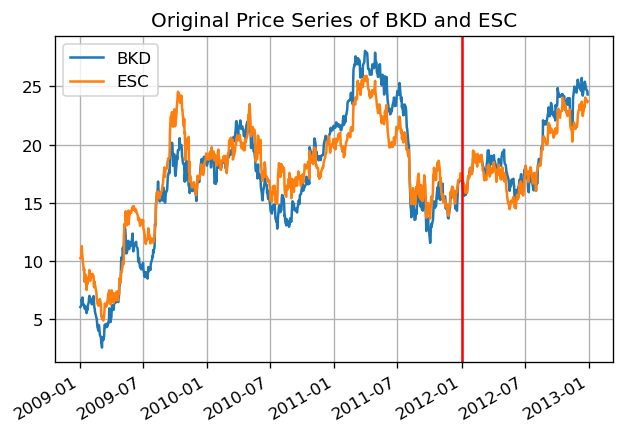

In [3]:
# Plotting data
plt.figure(dpi=120)
plt.plot(pair_prices['BKD'], label='BKD')
plt.plot(pair_prices['ESC'], label='ESC')
plt.axvline(dt.date(2012, 1, 3), color='red')  # Training testing split date
plt.legend()
plt.grid()
plt.gcf().autofmt_xdate()
plt.title(r'Original Price Series of BKD and ESC')
plt.show()

In [4]:
# Initiate the analysis module
BCS = BasicCopulaStrategy()

# Training and testing split
training_length = 756 # From 01/02/2009 to 12/30/2011 (m/d/y)

prices_train = pair_prices.iloc[: training_length]
prices_test = pair_prices.iloc[training_length :]

# Empirical CDF for the training set.
# This step is only necessary for plotting.
cdf1 = ccalc.construct_ecdf_lin(prices_train['BKD'])
cdf2 = ccalc.construct_ecdf_lin(prices_train['ESC'])

### 2. Fitting Data to Different Copulas with Training Data.
Here we fit to every copula type available in the module, and print out the scores in terms of SIC, AIC, and HQIC. The lower the score (Note they are all negative), the better the fit.

**Note**:<br>
1. `fit_copula` returns the fit result, the fitted copula, and marginal CDFs for the two input lists. Here the `cdf1`, `cdf2` is exactly the same as directly using `construct_ecdf_lin` function in `copula_calculation` module.
2. For `Student` copula, the MLE of $\nu$ is slow.
3. For mixed copulas, the fit is slow however they generally gives the best score.
4. You may need to tune the fitting parameters for mixed copulas: gamma_scad, a_scad to avoid warnings outputs.

In [5]:
# Fit different copulas, store the results in dictionaries
fit_result_gumbel, copula_gumbel, cdf1, cdf2 =\
    BCS.fit_copula(data=prices_train, copula_name='Gumbel')

fit_result_frank, copula_frank, cdf1, cdf2 =\
    BCS.fit_copula(data=prices_train, copula_name='Frank')

fit_result_clayton, copula_clayton, cdf1, cdf2 =\
    BCS.fit_copula(data=prices_train, copula_name='Clayton')

fit_result_joe, copula_joe, cdf1, cdf2=\
    BCS.fit_copula(data=prices_train, copula_name='Joe')

fit_result_cfg, copula_cfg, cdf1, cdf2=\
    BCS.fit_copula(data=prices_train, copula_name='CFGMixCop', gamma_scad=0.45)

fit_result_n14, copula_n14, cdf1, cdf2=\
    BCS.fit_copula(data=prices_train, copula_name='N14')

fit_result_gauss, copula_gauss, cdf1, cdf2 =\
    BCS.fit_copula(data=prices_train, copula_name='Gaussian')

fit_result_t, copula_t, cdf1, cdf2=\
    BCS.fit_copula(data=prices_train, copula_name='Student')

d:\apprenticeship\arbitragelab\arbitragelab\copula_approach\copula_generate.py:614: RuntimeWarning: invalid value encountered in double_scalars
  * (-1 + u_part * u + v_part * v) ** (-2 - 1 / theta))
D:\Programs\Anaconda\envs\mlfinlabenv\lib\site-packages\scipy\optimize\_numdiff.py:390: RuntimeWarning: invalid value encountered in less
  if np.any((x0 < lb) | (x0 > ub)):
D:\Programs\Anaconda\envs\mlfinlabenv\lib\site-packages\scipy\optimize\_numdiff.py:390: RuntimeWarning: invalid value encountered in greater
  if np.any((x0 < lb) | (x0 > ub)):
D:\Programs\Anaconda\envs\mlfinlabenv\lib\site-packages\scipy\optimize\_numdiff.py:405: RuntimeWarning: invalid value encountered in greater_equal
  sign_x0 = (x0 >= 0).astype(float) * 2 - 1
D:\Programs\Anaconda\envs\mlfinlabenv\lib\site-packages\scipy\optimize\_numdiff.py:63: RuntimeWarning: invalid value encountered in less
  violated = (x < lb) | (x > ub)
D:\Programs\Anaconda\envs\mlfinlabenv\lib\site-packages\scipy\optimize\_numdiff.py:63: R

**Note**: The warnings generated above is due to the optimization package by scipy not strictly following the prescribed bounds in the mixed copula fitting algo. And based on our experiments it does not influence the fit result with statistical significance. To completely get rid of the warnings, you will need to choose specific values `gamma_scad` and `a_scad` of the fitting parameter, and this heavily depends on the data."

In [6]:
# Print all the fit scores
print(fit_result_gumbel)
print(fit_result_frank)
print(fit_result_clayton)
print(fit_result_joe)
print(fit_result_cfg)
print(fit_result_n14)
print(fit_result_gauss)
print(fit_result_t)

{'Copula Name': 'Gumbel', 'SIC': -1450.7952464332018, 'AIC': -1455.4179827695934, 'HQIC': -1453.6406691250231, 'Log-likelihood': 728.7116439046906}
{'Copula Name': 'Frank', 'SIC': -1598.5589756582913, 'AIC': -1603.181711994683, 'HQIC': -1601.4043983501126, 'Log-likelihood': 802.5935085172354}
{'Copula Name': 'Clayton', 'SIC': -1643.0112976940648, 'AIC': -1647.6340340304564, 'HQIC': -1645.856720385886, 'Log-likelihood': 824.8196695351221}
{'Copula Name': 'Joe', 'SIC': -593.3513974011638, 'AIC': -597.9741337375556, 'HQIC': -596.1968200929853, 'Log-likelihood': 299.9897193886717}
{'Copula Name': 'CFGMixCop', 'SIC': -1755.426444007405, 'AIC': -1778.4866508883028, 'HQIC': -1769.6535574665124, 'Log-likelihood': 894.2833254441514}
{'Copula Name': 'N14', 'SIC': -1555.5351104717956, 'AIC': -1560.1578468081873, 'HQIC': -1558.380533163617, 'Log-likelihood': 781.0815759239875}
{'Copula Name': 'Gaussian', 'SIC': -1702.5448239518344, 'AIC': -1707.167560288226, 'HQIC': -1705.3902466436557, 'Log-likel

It seems by the score, CFG and Student-t are reasonable choices of copula that fit our training data the best.
Clayton also looks somewhat reasonable, although the tail dependency on the upper right corner is not taken into account.
So at first, we take a look at their information.

In [7]:
# Print copula descriptions
print(copula_cfg.describe(), '\n')
print(copula_t.describe(), '\n')
print(copula_clayton.describe(), '\n')

Descriptive Name    Bivariate Clayton-Frank-Gumbel Mixed Copula
Class Name                                            CFGMixCop
Clayton theta                                           6.79574
Frank theta                                             4.00431
Gumbel theta                                            5.89453
Clayton weight                                         0.803058
Frank weight                                                  0
Gumbel weight                                          0.196942
dtype: object 

Descriptive Name                                  Bivariate Student-t Copula
Class Name                                                           Student
cov                        [[1, 0.9548888277579829], [0.9548888277579829,...
rho                                                                 0.954889
nu (degrees of freedom)                                              13.6051
dtype: object 

Descriptive Name    Bivariate Clayton Copula
Class Name                

Now we plot the training data (as an empirical copula), together with $5$ other copulas fitted.

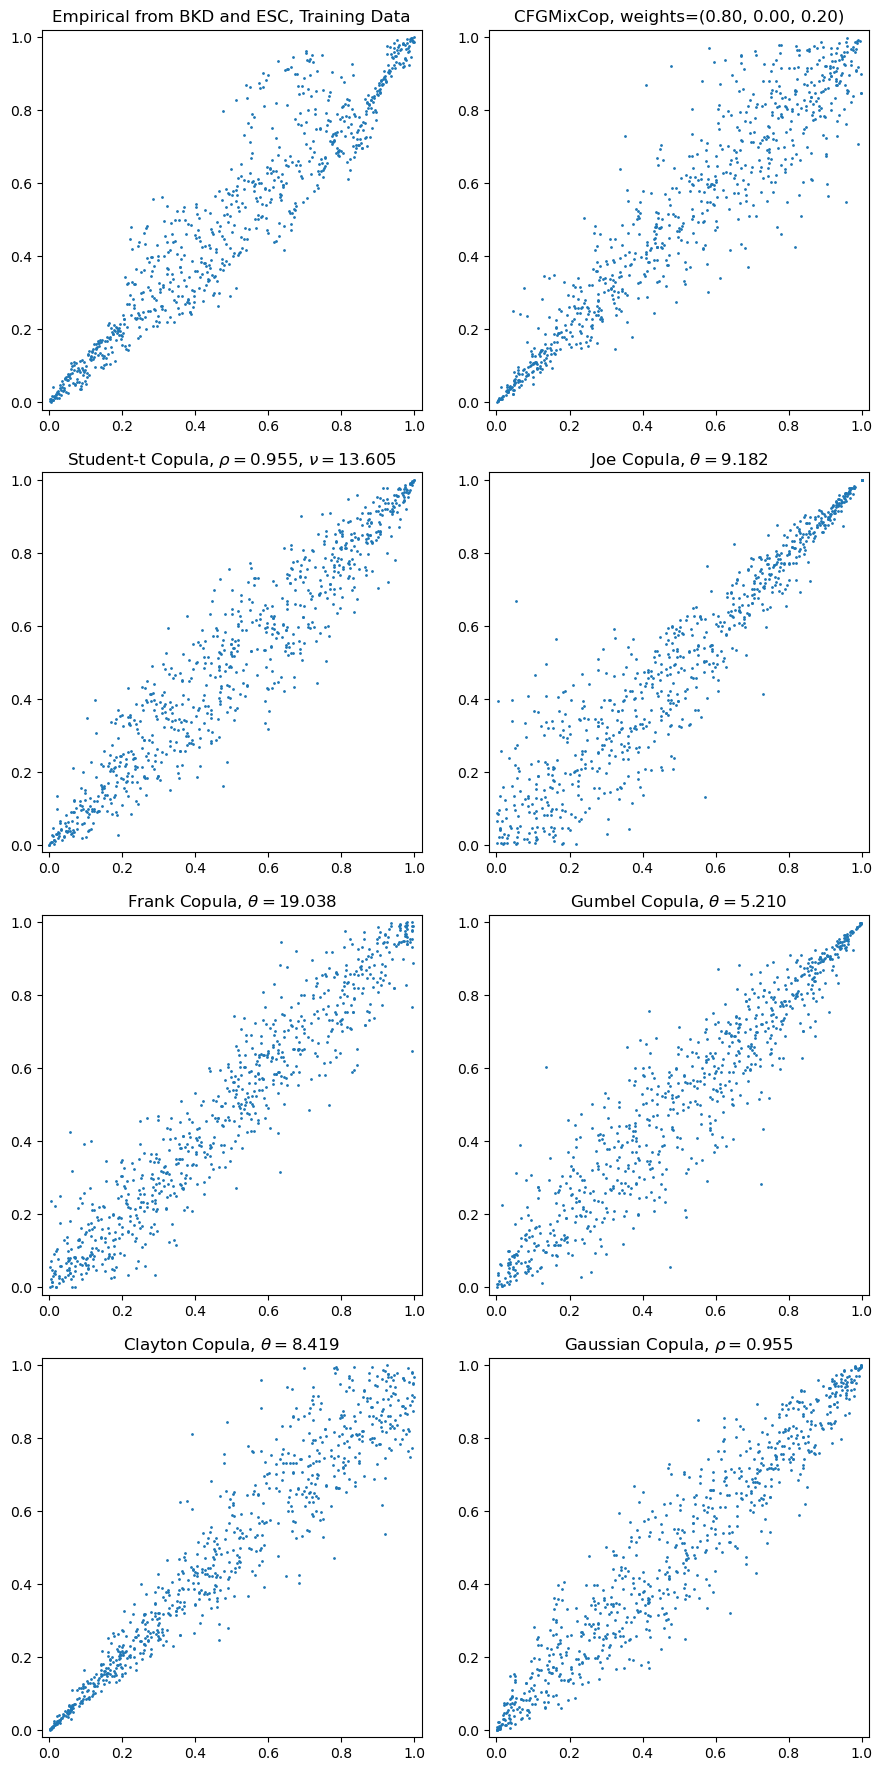

In [8]:
# Plotting copulas
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(9,18), dpi=100)

# axs[0, 0]: Empirical.
axs[0, 0].scatter(prices_train['BKD'].apply(cdf1), prices_train['ESC'].apply(cdf2), s=1)
axs[0, 0].set_aspect('equal', adjustable='box')
axs[0, 0].set_title(r'Empirical from BKD and ESC, Training Data')
axs[0, 0].set_xlim([-0.02, 1.02])
axs[0, 0].set_ylim([-0.02, 1.02])
plt.tight_layout()

# axs[0, 1]: N13.
copula_cfg.plot(ax=axs[0, 1], s=1, num=training_length)

# axs[1, 0]: Student-t.
copula_t.plot(ax=axs[1, 0], s=1, num=training_length)

# axs[1, 1]: Joe.
copula_joe.plot(ax=axs[1, 1], s=1, num=training_length)
                
# axs[2, 0]: Frank.
copula_frank.plot(ax=axs[2, 0], s=1, num=training_length)
                
# axs[2, 1]: Gumbel.
copula_gumbel.plot(ax=axs[2, 1], s=1, num=training_length)

# axs[3, 0]: Clayton.
copula_clayton.plot(ax=axs[3, 0], s=1, num=training_length)

# axs[3, 1]: Gaussian.
copula_gauss.plot(ax=axs[3, 1], s=1, num=training_length)

plt.show()

### 3. Generate Trading Positions Using Test Data
At first, we plot the testing data (as an empirical copula) and the two chosen copulas, together with three other copulas fitted.

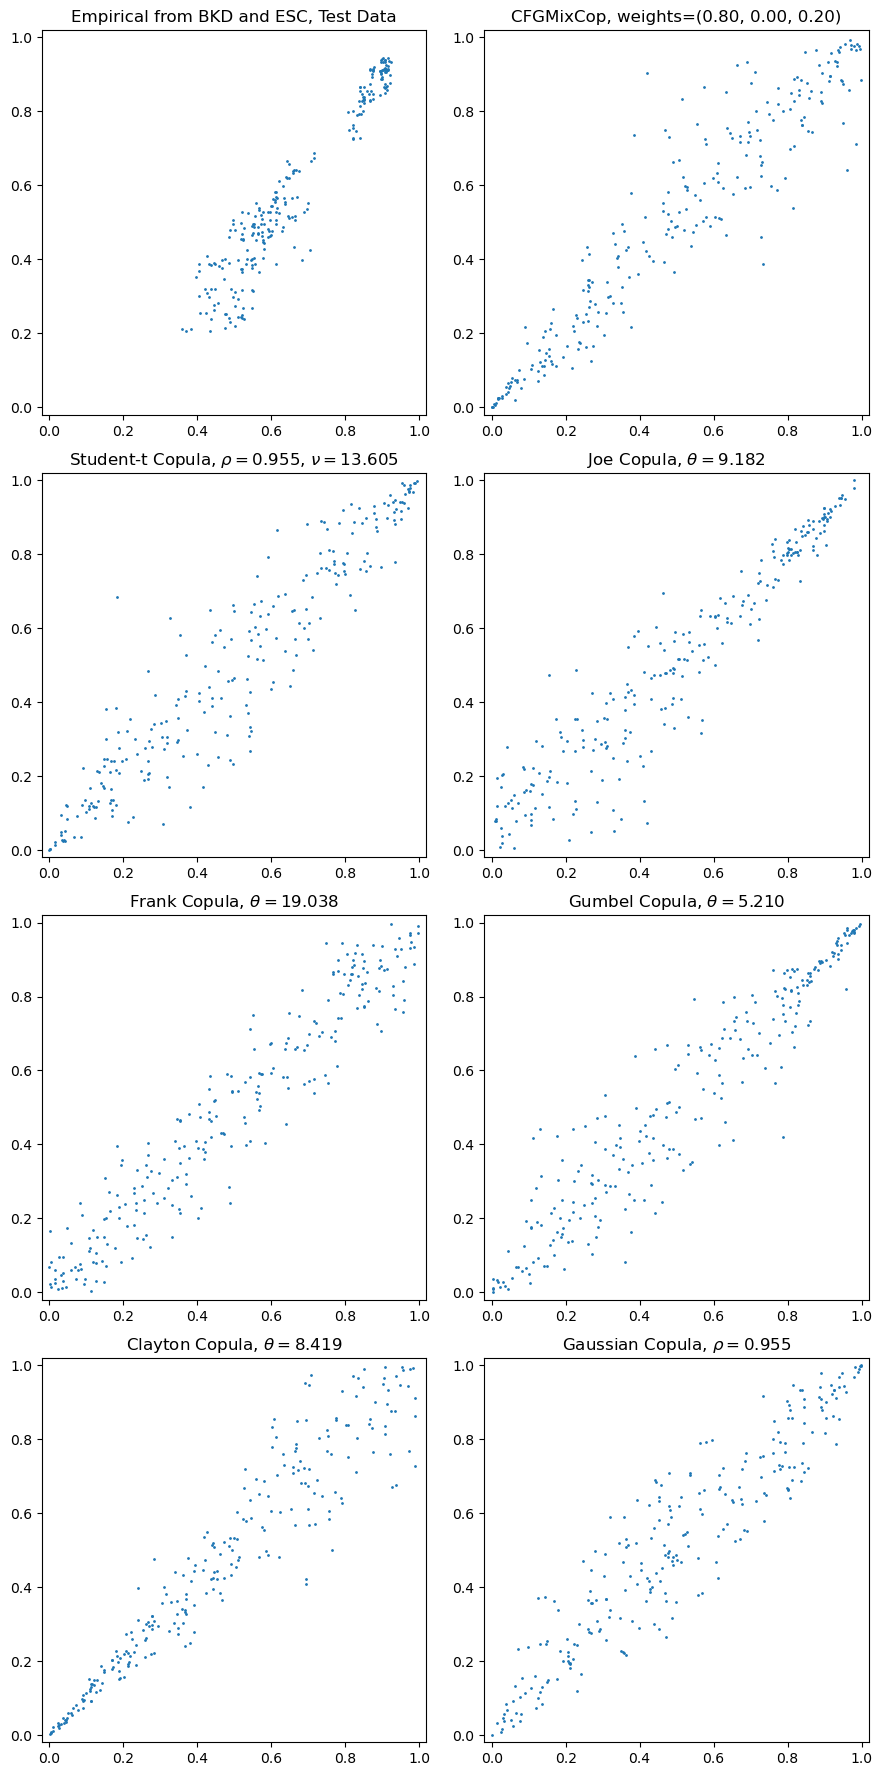

In [9]:
# Plotting copulas
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(9,18), dpi=100)

# axs[0, 0]: Empirical.
axs[0, 0].scatter(prices_test['BKD'].map(cdf1), prices_test['ESC'].map(cdf2), s=1)
axs[0, 0].set_aspect('equal', adjustable='box')
axs[0, 0].set_title(r'Empirical from BKD and ESC, Test Data')
axs[0, 0].set_xlim([-0.02, 1.02])
axs[0, 0].set_ylim([-0.02, 1.02])
plt.tight_layout()

test_length = len(prices_test)

# axs[0, 1]: N13.
copula_cfg.plot(ax=axs[0, 1], s=1, num=test_length)

# axs[1, 0]: Student-t.
copula_t.plot(ax=axs[1, 0], s=1, num=test_length)

# axs[1, 1]: Joe.
copula_joe.plot(ax=axs[1, 1], s=1, num=test_length)
                
# axs[2, 0]: Frank.
copula_frank.plot(ax=axs[2, 0], s=1, num=test_length)
                
# axs[2, 1]: Gumbel.
copula_gumbel.plot(ax=axs[2, 1], s=1, num=test_length)

# axs[3, 0]: Clayton.
copula_clayton.plot(ax=axs[3, 0], s=1, num=test_length)

# axs[3, 1]: Gaussian.
copula_gauss.plot(ax=axs[3, 1], s=1, num=test_length)

plt.show()

Then we get trading positions from the two chosen copulas.

**Note**:<br>
Although theoretically, one can change the threshold to potentially bring more trading opportunities, it needs to proceed with caution, as the recommended positions are very sensitive to the choice of copula and training data if the thresholds are not as strict.

#### Plot Trading Positions
Plot trading positions with recalculated cumulative log return (CLR) from test data, with the starting reference day as day 1 in the test data.

Here, 0 means no position, 1 means long the spread, -1 means short the spread.

**Note**:<br>
This is not the same as cumulative log returns used in the test data.
Suppose the training/testing split happens on day $755$, then the CLR is still calculated as $\ln(S(t))-\ln(S(0))$ for $t>755$.
However, we are plotting $\ln(S(t))-\ln(S(756))$, so that it is easier to see the spread and evaluate our recommended trading positions.
It is thus can be understood as a *repositioned log price*, or *reset cumulative log return*.

In [10]:
# Generate Trading Positions
# Use CFG copula.
# Those uses 'and' logic by default.
# Instantiate the CopulaStrategy with the fitted N13 copula.
BCS_cfg = BasicCopulaStrategy(copula=copula_cfg)
positions_cfg = BCS_cfg.get_positions(prices_test, cdf1, cdf2, open_thresholds=(0.05, 0.95),
                                      init_pos=0)  # Author used 0.05 and 0.95, it is thus optional.
# Use Student-t Copula.
# Instantiate the CopulaStrategy with the fitted Student-t copula.
BCS_t = BasicCopulaStrategy(copula=copula_t)
positions_t = BCS_t.get_positions(prices_test, cdf1, cdf2, open_thresholds=(0.05, 0.95),
                                  init_pos=0)
# Use Clayton copula.
# Instantiate the CopulaStrategy with the fitted Clayton copula.
BCS_clayton = BasicCopulaStrategy(copula=copula_clayton)
positions_clayton = BCS_clayton.get_positions(prices_test, cdf1, cdf2, open_thresholds=(0.05, 0.95),
                                              init_pos=0)

# Instantiate the CopulaStrategy with the fitted N13 copula.
# Use 'or' logic.
BCS_cfg = BasicCopulaStrategy(copula=copula_cfg)
positions_cfg_or = BCS_cfg.get_positions(prices_test, cdf1, cdf2, open_thresholds=(0.05, 0.95),
                                      init_pos=0, exit_rule='or')

# Roll all positions forward by 1 day
positions_cfg = positions_cfg.shift(1)
positions_t = positions_t.shift(1)
positions_clayton = positions_clayton.shift(1)
positions_cfg_or =positions_cfg_or.shift(1)

# Reset position at day 0
positions_cfg[0] = 0
positions_t[0] = 0
positions_clayton[0] = 0
positions_cfg_or[0] = 0

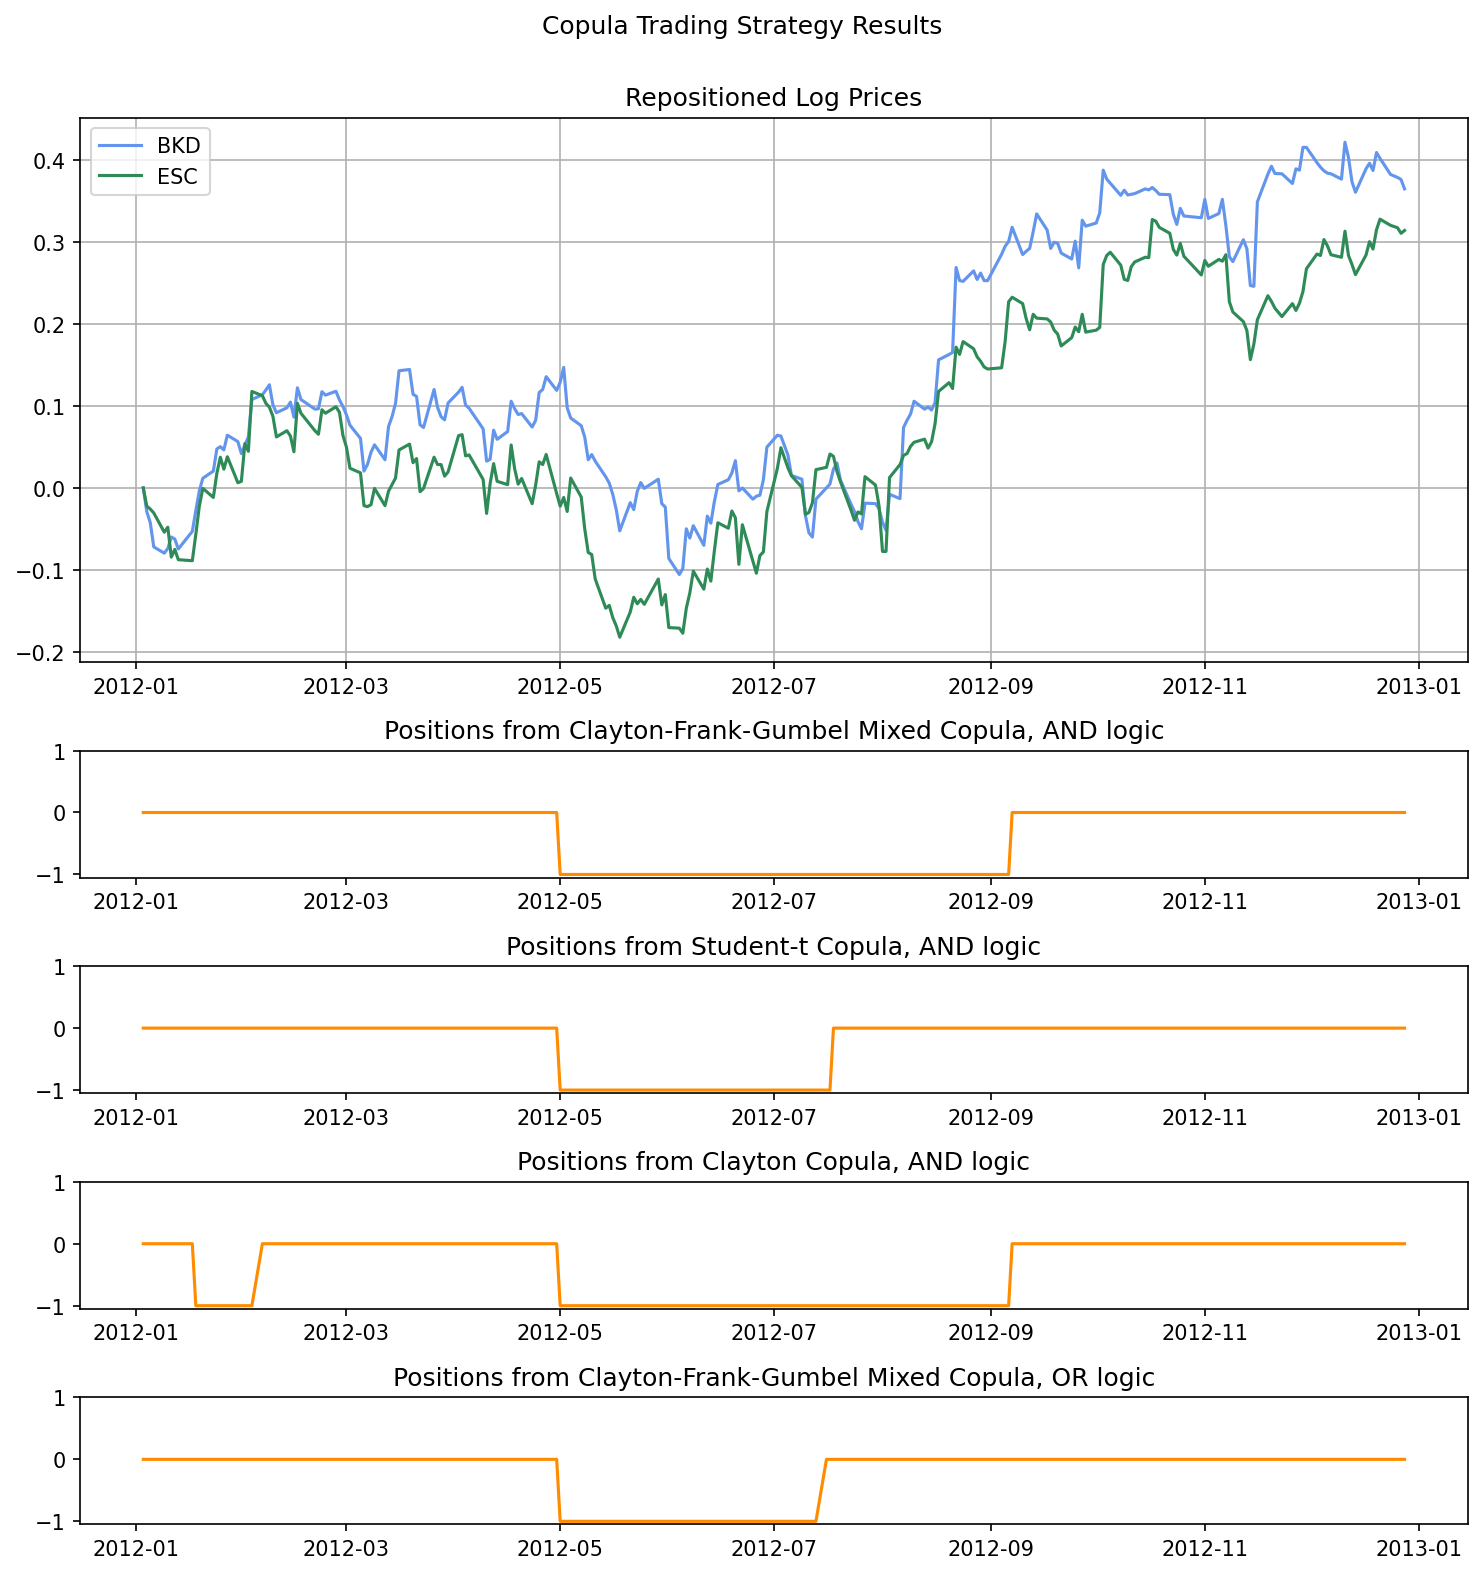

In [11]:
# Plotting generated positions
fig, axs = plt.subplots(5, 1, gridspec_kw={'height_ratios': [3, 0.7, 0.7, 0.7, 0.7]}, figsize=(10,11), dpi=150)
fig.suptitle('Copula Trading Strategy Results')

# Plotting repositioned log prices
axs[0].plot((prices_test['BKD'] / prices_test['BKD'][0]).map(np.log), label='BKD', color='cornflowerblue')
axs[0].plot((prices_test['ESC'] / prices_test['ESC'][0]).map(np.log), label='ESC', color='seagreen')
axs[0].title.set_text('Repositioned Log Prices')
axs[0].legend()
axs[0].grid()

# Plotting positions from CFG
axs[1].plot(positions_cfg, label='Positions', color='darkorange')
axs[1].title.set_text('Positions from Clayton-Frank-Gumbel Mixed Copula, AND logic')
axs[1].set_yticks([-1,0,1])

# Plotting positions from Student-t
axs[2].plot(positions_t, label='Positions', color='darkorange')
axs[2].title.set_text(r'Positions from Student-t Copula, AND logic')
axs[2].set_yticks([-1,0,1])

# Plotting positions from Clayton
axs[3].plot(positions_clayton, label='Positions', color='darkorange')
axs[3].title.set_text(r'Positions from Clayton Copula, AND logic')
axs[3].set_yticks([-1,0,1])

# Plotting positions from CFG
axs[4].plot(positions_cfg_or, label='Positions', color='darkorange')
axs[4].title.set_text(r'Positions from Clayton-Frank-Gumbel Mixed Copula, OR logic')
axs[4].set_yticks([-1,0,1])

fig.tight_layout(rect=[0, 0.03, 1, 0.95])  # Avoid title overlap
plt.show()

#### Equity Curve for the Portfolio
1. Defining weights (hedging ratio)
2. Calculating returns
3. Portfolio prices
4. Equity curve for copula strategy

There are multiple methods to define weights.
For example, using OLS or Johansen test on training data.
Here we define weights as below to reflect the (repositioned) series mentioned above:
At first, we define the unnormalized weight $w_{1}^* = w_{BKD}$ and $w_2^* = w_{ESC}$ for $S_1 = S_{BKD}$ and $S_2 = S_{ESC}$ as follows:
$$
w_{1}^* S_{1}[0] - w_{2}^* S_{2}[0] = 0
$$
with another arbitrary linear constraint
$$w_1^* - w_2^* = 1.$$
So that it has value $0$ initially.
Hence
$$
w_1^* = -\frac{S_2[0]}{S_1[0]-S_2[0]}, \quad
w_2^* = -\frac{S_1[0]}{S_1[0]-S_2[0]}.
$$
Then we normalize them so that
$$
w_1 = \frac{w_1^*}{w_1^* + w_2^*}, \quad
w_2 = \frac{w_2^*}{w_1^* + w_2^*}
$$

In [12]:
# 1. Calculating weights
w1_star = -prices_test['ESC'][0] / (prices_test['BKD'][0] - prices_test['ESC'][0])
w2_star = w1_star - 1

w1 = w1_star / (w1_star + w2_star)
w2 = w2_star / (w1_star + w2_star)

print('Unnormalized weight: \n\
w1_star={}, \nw2_star={},\n\
Normalized weight:\n\
w1={} \nw2={}'.format(w1_star, w2_star, w1, w2))

Unnormalized weight: 
w1_star=39.363546901029565, 
w2_star=38.363546901029565,
Normalized weight:
w1=0.5064327633459873 
w2=0.49356723665401275


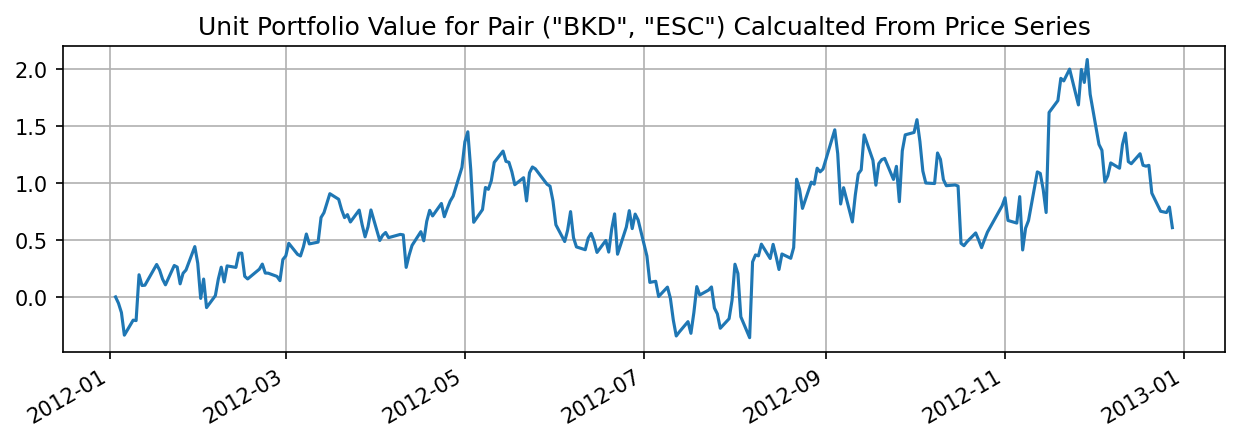

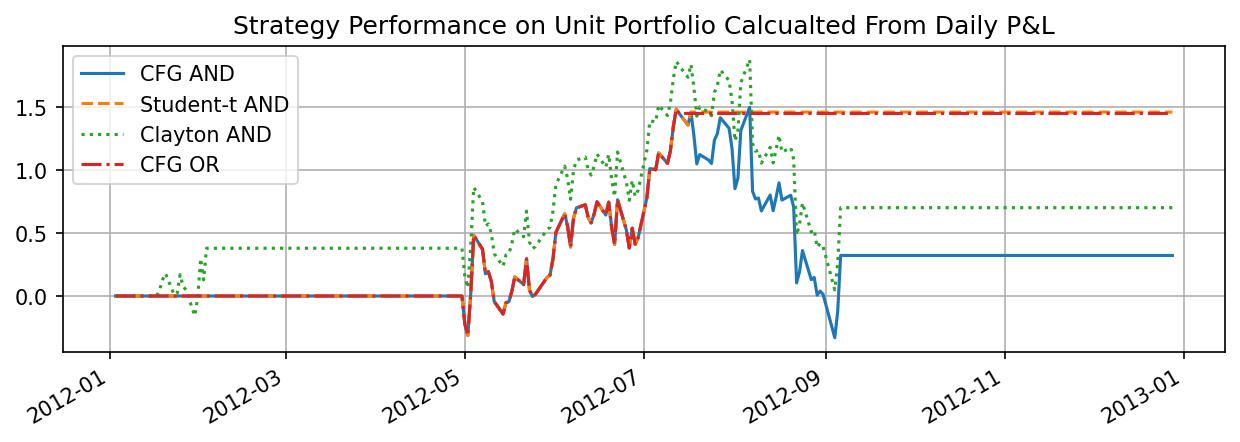

In [13]:
# 2. Calculating Portfolio Series and daily P&L
portfolio_prices = w1 * prices_test['BKD'] - w2 * prices_test['ESC']
portfolio_pnl = np.diff(portfolio_prices, prepend=0)

# 3. Plotting portfolio prices
fig, ax = plt.subplots(figsize=(10,3), dpi=150)
ax.plot(portfolio_prices)
ax.title.set_text('Unit Portfolio Value for Pair ("BKD", "ESC") Calcualted From Price Series')
ax.grid()
fig.autofmt_xdate()
plt.show()

# 4. Calculating strategy daily P&L
pnl_cfg = portfolio_pnl * positions_cfg
pnl_t = portfolio_pnl * positions_t
pnl_clayton = portfolio_pnl * positions_clayton
pnl_cfg_or = portfolio_pnl * positions_cfg_or
equity_cfg = pnl_cfg.cumsum()
equity_t = pnl_t.cumsum()
equity_clayton = pnl_clayton.cumsum()
equity_cfg_or = pnl_cfg_or.cumsum()

fig, ax = plt.subplots(figsize=(10,3), dpi=150)
ax.plot(equity_cfg, label='CFG AND')
ax.plot(equity_t, '--', label=r'Student-t AND')
ax.plot(equity_clayton, ':', label=r'Clayton AND')
ax.plot(equity_cfg_or, '-.', label='CFG OR')
ax.title.set_text('Strategy Performance on Unit Portfolio Calcualted From Daily P&L')
ax.grid()
fig.autofmt_xdate()
ax.legend()
plt.show()

### 4. Possible Issues Discussion

#### Data Processing
Log prices or CLR are not fundamentally stationary, and especially in real data, the training period may differ significantly from the testing period, rendering testing period data out of range.
One may consider other alternatives.

#### Copula Fitting
The fitting results are very sensitive to the inputs.
And more often than not, the fit score among copulas are not very different from each other.
In this case, one should look at the few best-suited copulas as candidates, instead of using a single copula.

#### Copula Modeling
Modeling and trading a pair of stocks' movements using copula, as implemented in the module, treats each stocks time series data as a random variable with stationary distribution.
Though mathematically valid, this approach does not take into account each random variable as a time series, and re-shuffle the training data will yield the exact same result in terms of  fitted copula parameters and thus recommended positions.
However, when compared to a vanilla Euclidean distance approach, this is one step further.

Moreover, all the commonly used copulas are either Archimedean (Gumbel, Frank, etc.) or Elliptic (Student-t, Gaussian), which share some nice properties such as symmetry.
However, the best-suited copula behind a pair of stocks may not necessarily be symmetric.

## Conclusion
(This section follows from [Liew et al. 2013])<br>
Copula introduces delicate assumptions on the exact coupled structure, along with other nice properties, of two random variables.
In the pairs trading context, two stocks time series.

* When compared to the Euclidean distance or cointegration approach, copula does not rely on assumptions of linear association or correlation coefficients as a measure of dependency.

* Copula-based approach results in a far richer set of information, such as the shape and nature of the dependency between the stock pairs, thereby leading to potentially more robust modeling of the pair.

* Some copula choices measure well with upper and lower tail dependencies of different extent, in an environment that considers both linear and non-linear relationship. 

* Copulas possess an attractive property of being invariant under strictly monotone transformations of random variables. In other words, the same copula will be obtained regardless of whether the analyst is using price series or log price series.

## References ##
- [Liew, R.Q. and Wu, Y., 2013. Pairs trading: A copula approach. Journal of Derivatives & Hedge Funds, 19(1), pp.12-30.](https://link.springer.com/article/10.1057/jdhf.2013.1)
- [Stander, Y., Marais, D. and Botha, I., 2013. Trading strategies with copulas. Journal of Economic and Financial Sciences, 6(1), pp.83-107.](https://www.researchgate.net/publication/318054326_Trading_strategies_with_copulas)